### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
%matplotlib inline

pd.set_option('precision', 3)

### Importing the dataset

In [2]:
labels = ('fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides','free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol','quality')
df_red = pd.read_csv('Datasets/winequality-red.csv', header = 0, names = labels,sep = ';')
# df_white = pd.read_csv('Datasets/winequality-white.csv', header = 0, names = labels,sep = ';')

### Display the dataset

In [3]:
df_red.head(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,5


In [4]:
def drop_constant_column(dataframe):
    return dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]

def cleanDf(df):
    columns_len = len(df.columns)
    # clear empty or "singular" columns
    df = df.dropna(axis='columns', how='all')
    df = drop_constant_column(df)
    len_before_drop = len(df)
    df = df.drop_duplicates()
    print(f"Loaded {len_before_drop} records, removed {len_before_drop - len(df)} duplicates, left {len(df)}, removed {columns_len-len(df.columns)} of {columns_len} columns")

    return df

#### Dropping the Duplicate Values

In [5]:
df_red = cleanDf(df_red)
# df_white = cleanDf(df_white)

Loaded 1599 records, removed 240 duplicates, left 1359, removed 0 of 12 columns


## Exploratory Data Analysis

In [6]:
def get_features(df, label, threshold):
    correlations = df.corr()[label].drop(label)
    features = correlations[correlations.abs() > threshold].index.tolist()
    df_filtered = df[features + [label]]

    return df_filtered, features, correlations

In [7]:
label = 'quality'
df_red_features, features, _ = get_features(df_red, label, 0.1)

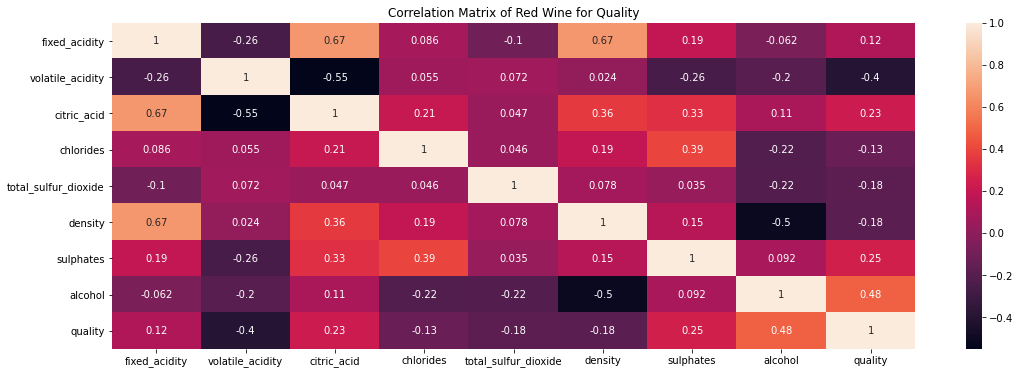

In [8]:
plt.figure(figsize=(18,6))
sns.heatmap(df_red_features.corr(),annot=True)
plt.title('Correlation Matrix of Red Wine for Quality');

# Compare Predictions for Red Wine

### Splitting into Train and Test sets

In [9]:
from sklearn.model_selection import train_test_split

X = df_red[features]
y = df_red[label]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [10]:
X.head(2)

,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,sulphates,alcohol
0,7.4,0.70,0.0,0.076,34.0,0.998,0.56,9.4
1,7.8,0.88,0.0,0.098,67.0,0.997,0.68,9.8


In [11]:
y.head(2)

0    5
1    5
Name: quality, dtype: int64

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
lr_train_pred = lr.predict(X_train)
print(f'Train Prediction: {lr_train_pred[:15].astype(int)}\n   Actual values: {y_train[:15].values}')
lr_test_pred = lr.predict(X_test)
print(f'Test  Prediction: {lr_test_pred[:15].astype(int)}\n   Actual values: {y_test[:15].values}')

Train Prediction: [5 5 5 5 5 6 4 5 4 5 6 6 5 6 5]
   Actual values: [5 7 6 5 5 6 5 7 5 6 6 7 5 7 5]
Test  Prediction: [6 4 6 6 5 6 5 6 6 6 5 5 5 5 4]
   Actual values: [5 5 6 7 6 6 5 7 7 6 6 6 6 5 4]


In [14]:
lr_rmse_train = metrics.mean_squared_error(lr_train_pred, y_train) ** 0.5
print(f'LinearRegression train RMSE {lr_rmse_train:.2f}')

lr_rmse_test = metrics.mean_squared_error(lr_test_pred, y_test) ** 0.5
print(f'LinearRegression test  RMSE {lr_rmse_test:.2f}')

LinearRegression train RMSE 0.64
LinearRegression test  RMSE 0.69


#### Using AUTO ML

In [15]:
import autosklearn
from sklearn.metrics import mean_absolute_error
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_absolute_error as auto_mean_absolute_error
print(f'autosklearn: {autosklearn.__version__}')

autosklearn: 0.12.6


In [16]:
def prediction_out(name, estimator):
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)
    rmse_train = metrics.mean_squared_error(train_pred, y_train) ** 0.5
    rmse_test = metrics.mean_squared_error(test_pred, y_test) ** 0.5
    print(f'{name} train RMSE {rmse_train:.2f}')
    print(f'{name} test  RMSE {rmse_test:.2f}')
    return rmse_train, rmse_test

In [17]:
# define search
model_mae = AutoSklearnRegressor(time_left_for_this_task=7*65, metric=auto_mean_absolute_error, per_run_time_limit=65, n_jobs=-1)

In [18]:
# perform the search
%time model_mae.fit(X_train, y_train)

CPU times: user 6min 13s, sys: 16.9 s, total: 6min 30s
Wall time: 7min 43s


AutoSklearnRegressor(metric=mean_absolute_error, n_jobs=-1,
                     per_run_time_limit=65, time_left_for_this_task=455)

In [19]:
# summarize
print(model_mae.sprint_statistics())
# evaluate best model_mae
ar_train_pred = model_mae.predict(X_train)
ar_test_pred = model_mae.predict(X_test)
mae = mean_absolute_error(y_test, ar_test_pred)
print(f"MAE: {mae:.2f}")

auto-sklearn results:
  Dataset name: 09a0d323-e01c-11eb-a6a0-2b5953d8fa21
  Metric: mean_absolute_error
  Best validation score: 0.475367
  Number of target algorithm runs: 71
  Number of successful target algorithm runs: 58
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 13
  Number of target algorithms that exceeded the memory limit: 0

MAE: 0.51


In [20]:
prediction_out('AutoSklearn', model_mae)

AutoSklearn train RMSE 0.58
AutoSklearn test  RMSE 0.68


(0.582977282580522, 0.6758518853111751)

**KERAS**

In [33]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import logging
tf.get_logger().setLevel(logging.ERROR)

In [34]:
# define base model wraper
def baseline_model_arg(activation_type):
    # create model
    def baseline_model():
        model = Sequential()
        model.add(Dense(12, input_dim=8, kernel_initializer='normal', activation=activation_type))
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    return baseline_model

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [39]:
#define keras model function serealization
def KerasRMSE(epoch, batches, activator):
    kfold_s = KFold(n_splits=10)
    estimator_ks = KerasRegressor(build_fn=baseline_model_arg(activator), epochs=epoch, batch_size=batches, verbose=0)
    %time results_s = cross_val_score(estimator_ks, X, y, cv=kfold_s)
    callbacks_list = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=f'./logs/{date.today().strftime("%b-%d-%Y")}'),]
    estimator_ks.fit(X_train, y_train, validation_split=0.33, callbacks=callbacks_list)
                    
    return estimator_ks

In [46]:
activations = ['relu', 'sigmoid', 'softmax', 'softplus']
def KerasAuto():
    estimator_ks_1 = KerasRMSE(600, 50, 'relu')
    o1, o2 = prediction_out('keras {600, 50}', estimator_ks_1)
    for activator in activations:
        i = 600
        while i <= 800:
            estimator_ks_2 = KerasRMSE(i, 50, activator)
            l1, l2 = prediction_out(f'keras {i} 50', estimator_ks_2)
            if l2 > o2 and abs(o2 - o1) < abs(l2 - l1):
                break
            if l2 < o2:
                o1 = l1
                o2 = l2
                estimator_ks_1 = estimator_ks_2
            print(f'{activator, i}')
            i += 200
    return estimator_ks_1
    

In [ ]:
estimator_ks_1 = KerasAuto()

CPU times: user 3min 55s, sys: 23.3 s, total: 4min 19s
Wall time: 2min 12s
keras {600, 50} train RMSE 0.74
keras {600, 50} test  RMSE 0.76
CPU times: user 4min 10s, sys: 25.3 s, total: 4min 35s
Wall time: 2min 21s
keras (600,) 50 train RMSE 0.72
keras (600,) 50 test  RMSE 0.74
('relu', 600)


KeyboardInterrupt: 

In [ ]:
prediction_out('linear', lr)
prediction_out('AutoSklearn', model_mae)
prediction_out('keras', estimator_ks_1)

**CONCLUSION:** The best results

In [ ]:
keras_test_pred = estimator_ks_1.predict(X_test)
model_mae_test_pred = model_mae.predict(X_test)
print(f'Test  Prediction: {lr_test_pred[:30].astype(int)}\n')
print(f'Test  Prediction: {keras_test_pred[:30].astype(int)}\nTest  Prediction: {model_mae_test_pred[:30].astype(int)}\n   Actual values: {y_test[:30].values}')